### MODULES
All the modules, constant, imports and libraries used

In [516]:
import pandas as pd
import numpy as np
from Map import Map
from SplitPois import SplitPois
import seaborn as sns

FILE_INPUT_TSV = 'pois_all_info'
INPUT_IDS = 'ny_municipality_pois_id.csv'
PERCENTAGE_TO_PRINT_DATA = 0.30
CATEGORIES = {"amenity", 'public_transport', 'shop', 'highway'}
PHOTO_PATH = 'New_York_City_Map.PNG'

### READS THE MUNICIPALITY FILE
Reads the file containing the id of all the elements inside the municipality of New York. <br>
The file is organized as it follows: 
<ul>
<li>one id per row, where each id is a POI in New York municipality</li>
</ul>
Returns:
<ul>
<li>The list of IDs</li>
</ul>

In [517]:
def readIds(file:str)->list[str]:
    """reads the id of the municipality of New York

    Args:
        file (str): the path of the file containing the IDs

    Returns:
        list[str]: the list of ids
    """
    with open(file, "r", encoding='UTF-8') as fp:
        return [int(row.strip()) for row in fp]

### 1 - READ TSV FILE
Reads the tsv file containing all the filtered data, the file is organized as it follows:
<ul>
<li>@id: a unique id for each point of interest.</li>
<li>@lat: latitude coordinate of the POI in decimal degrees.</li>
<li>@lon: longitude coordinate of the POI in decimal degrees.</li>
<li>amenity name: if the POI category is amenity its type is reported in this field.</li>
<li>shop: if the POI category is shop its type is reported in this field.
<li>public_transport: if the POI category is public transport its type is reported in this field.</li>
<li>highway: if the POI category is highway its type is reported in this field.</li>
</ul>

The function requires as inputs:
<ol>
<li>The path to the file containing all the data of POI</li>
<li>The path to the file containing all the ids of the POI in NY municipality</li>
</ol>

Returns:
<ol>
<li>A dataFrame containing the mentioned columns and that uses @id as index</li>
</ol>

In [518]:
def readPOIs(dataFile:str, POIsUnique:str)->pd.DataFrame:
    """
    Reads the data and saves them into a pandas dataFrame

    Args:
        dataFile (str): the file of the path containing the TSV
        POIsUnique (str): the file containing the IDs of New York

    Returns:
        DataFrame (pd.DataFrame): The data frame containing all the given data of the municipality of New York
    """
    df = (pd.read_csv(dataFile, sep='\t', header=0, encoding='UTF-8', 
                    # usecols=[0,2,3,4,5,6,7,8], # skips the column type which only contains the value node
                    dtype={'@id':int, 'name':str, 'amenity':str,'shop':str, 
                            'public_transport':str,'highway':str})
        )
    
    return df[df['@id'].isin(readIds(POIsUnique))].set_index(keys='@id')

### 2 - Missing value analysis
For each column in the loaded dataset count the number of missing values.
- What did you expect?
- What can you infer from this first analysis?

In [519]:
def missingValueAnalysis(df:pd.DataFrame)->None:
    display(df.isna().sum())

### 3 - PLOTS THE HISTOGRAM OF ALL POIs

This function plots the histogram of all the columns here (for the most important possible class)

In [520]:
def plotPOIHistogram(df:pd.DataFrame, percentage:float, columns:set[str]) -> None:
    """plots the histogram of the columns present in the dataFrame

    Args:
        df (pd.DataFrame): dataFrame
        percentage (float): the percentage threshold minimum required for printing
        columns (set[str]): the set of columns to be printed
    """
    for item in list(columns):
        temp = df.loc[:, item].value_counts()
        pd.DataFrame(temp[temp>percentage*max(temp)]).plot.bar()

### 4 - PLOT POI

Show the points of interest on the New York map for a given category (e.g. amenity). To do so, you
have to define a new function (or a new class) that, given the name of the POI category is able to
show a scatter plot of the locations of the POI types, onto the New York municipality map, with a
different color for each category.
- Are you able to identify areas in which the concentration of a specific POI type is higher then
others?
- How can you better characterize the POI distributions?

In [521]:
def plotPOIS(pois:pd.DataFrame, type:str, foto:str)->None:
    """
    Plot the New York map with POIs of a specific category.
    """
    
    ny_map = Map(pois[pois[type].isin({x for x,y in pois[type].value_counts().items() if y > 500})])
    
    ax = ny_map.plot_map(foto)
    ny_map.plot_pois(ax, type)

### 5 - Discretization of cell location

Discretize the POIs by geographical position. Define a new function (or class) that is able to split the
geographical position of the POIs using a grid. Once defined the grid over the New York municipality,
the function has to assign each POI to the cell to which it belongs to. The result should be a Pandas
DataFrame with a new column containing the cell_id for each POI

In [522]:
def splitPoisIntoCellMap(pois_df:pd.DataFrame, size:int):
    cell_conv = SplitPois(pois_df, size)

    pois_df.insert(loc=3, column='cell_id', value=pois_df.apply(lambda x: cell_conv.point_to_cell_id(x['@lon'], x['@lat']), axis=1))
    return cell_conv

### 6 - POIs location count
Now you have to identify how many times a POI type is contained in each cell, for each category.<br>
Create a new DataFrame containing the cell_id as index, the POI types as columns and the count
of the occurrences of each type, in each cell, as values.

In [523]:
def POIsMapLocation(pois:pd.DataFrame, type:str, threshold:int)->pd.DataFrame:
    df = pd.DataFrame(data=pois[~pois[type].isna()].loc[:, ['cell_id', 'name']].groupby(['cell_id']).agg(func='count'),
                        index=pois['cell_id'].unique()).replace(to_replace={np.nan:0})
    
    for x,y in pois[type].value_counts().items():
        if y > threshold:
            df.insert(loc=len(df.columns), column=x, value=pois[pois[type]==x].loc[:, ['cell_id', type]].groupby('cell_id').count())
            
    return df.replace(to_replace={np.nan:0}).drop(labels=['name'], axis=1).sort_index()


### 7 - Correlation detection
For the categories amenities and shop identify if there exist a correlation between the location of different POI types. 
<br> Compute the pairwise correlation between the columns of the cell-type DataFrame and show it through a heatmap chart.
- Are you able to identify which are the POI types more correlated between each other? What
does it mean?
- Which are the more correlated tuples? Do they belong to the same category?


In [524]:
def correlationDetection(df:pd.DataFrame):
    sns.heatmap(data=df.corr())

## MAIN FUNCTION
This is the main function of the file that will control the flow of the program, it executes what follows:
<ol>
<li>Reads the file containing all POIs (already filtered)</li>
<li>Performs the analysis of missing values</li>
<li>Plots the histogram of the distribution types only for data above a certain threshold</li>
<li>Plots the scatter plot of the location of POIs type </li>
<li>Maps the location into a grid</li>
<li>Identifies the type of poi for each cell</li>
<li>Identifies if exists a correlation between the location of different POI types</li>
</ol>


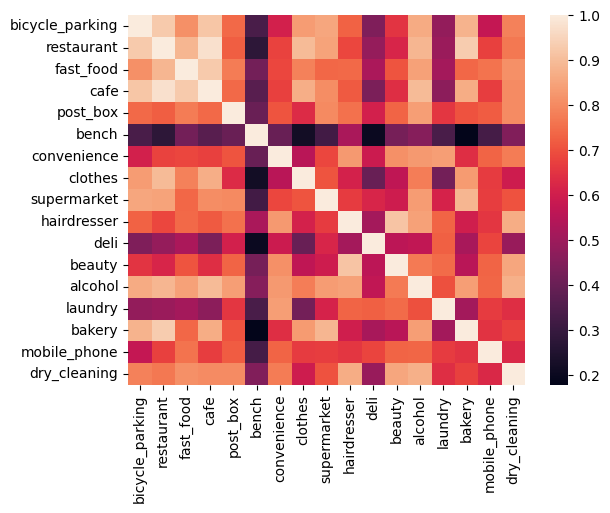

In [525]:
def main()->None:
    pois = readPOIs(FILE_INPUT_TSV, INPUT_IDS) # 1
    #pois.info() # 2
    #pois.describe() # 2
    #missingValueAnalysis(pois) #2
    # plotPOIHistogram(pois, PERCENTAGE_TO_PRINT_DATA, CATEGORIES) # 3
    
    # display(pois[pois.loc[:, ["amenity", "name", "shop", "public_transport", "highway"]].isna().sum(axis=1)==2])
    
    # Drops all row with all empty columns
    # pois = pois.drop(labels=pois[pois.loc[:, ["amenity", "name", "shop", "public_transport", "highway"]].isna().sum(axis=1)>4].index)
    
    # plotPOIS(pois, 'amenity', PHOTO_PATH) # 4 
    
    
    # ax = Map(pois).plot_map(PHOTO_PATH) # 5
    splitPoisIntoCellMap(pois, 20)
            #.plotGrid(ax) # 5
    
    amenityLoc = POIsMapLocation(pois, 'amenity', 1050) # 6
    
    correlationDetection(amenityLoc.join(POIsMapLocation(pois, 'shop', 160)).replace(to_replace={np.nan:0})) # 7
    
main()